[EP11] 인공지능으로 세상에 없던 새로운 패션 만들기

<<목차>>


1) 작업환경 구성하기

2) 데이터셋 구성하기

3) 생성자 모델 구현하기

4) 판별자 모델 구현하기

5) 손실함수와 최적화 함수 구현하기

6) 훈련과정 상세 기능 구현하기

7) 학습 과정 진행하기

8) (optional) GAN 훈련 과정 개선하기

9) 루브릭

10) 회고

In [384]:
import os
import glob
import time
import random

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.10.0


In [356]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [360]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [362]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


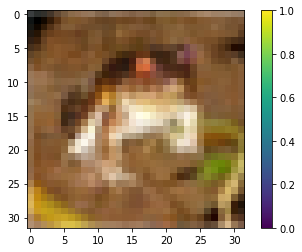

In [382]:
plt.imshow((train_x[0]+1)/2)
plt.colorbar()
plt.show()

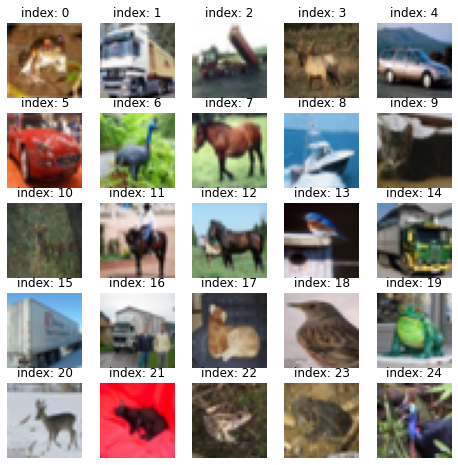

In [393]:
plt.figure(figsize=(8, 8))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[i]+1)/2)
    plt.title(f'index: {i}')
    plt.axis('off')

plt.show()

In [394]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [395]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2022-10-27 00:50:07.492917: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1228800000 exceeds 10% of free system memory.


In [402]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='ReLU'))

    return model

In [403]:
generator = make_generator_model()

generator.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 16384)             1638400   
                                                                 
 batch_normalization_37 (Bat  (None, 16384)            65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_13 (Reshape)        (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_36 (Conv2D  (None, 8, 8, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_38 (Bat  (None, 8, 8, 128)      

In [404]:
noise = tf.random.normal([1, 100])

In [405]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

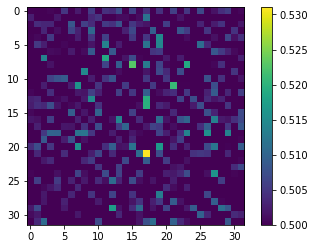

In [408]:
plt.imshow((generated_image[0, :, :, 0]+1)/2)
plt.colorbar()
plt.show()

In [409]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [410]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        4864      
                                                                 
 leaky_re_lu_50 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 dropout_10 (Dropout)        (None, 16, 16, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_51 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_11 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 flatten_5 (Flatten)         (None, 8192)            

In [411]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00037564]], dtype=float32)>

In [414]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [416]:
vector = [[1, 2, 3],
          [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [417]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [418]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [419]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [420]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [421]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [422]:
@tf.function    # @tf.function 데코레이터가 적용되었습니다.
def f(x, y):
  print(type(x))
  print(type(y))
  return x ** 2 + y

x = np.array([2, 3])
y = np.array([3, -2])
f(x, y)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<tf.Tensor: shape=(2,), dtype=int64, numpy=array([7, 7])>

In [423]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [426]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('/home/june/Github/Exploration/data/ep11/savefig/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [428]:
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('/home/june/Github/Exploration/data/ep11/trainhistory/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [254]:
checkpoint_dir = '/home/june/Github/Exploration/data/ep11/training_checkpoints/training_checkpoints'

checkpoint_prefix = checkpoint_dir
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [255]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [433]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

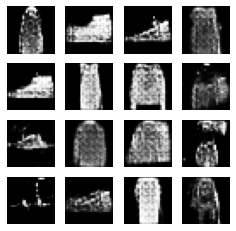

Time for training : 411 sec


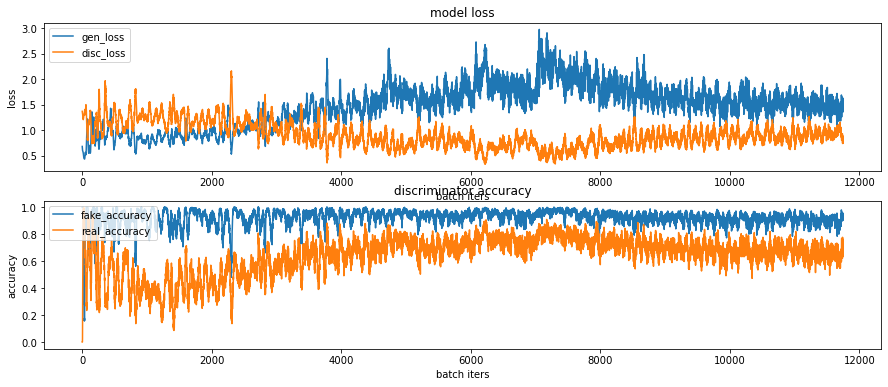

CPU times: user 4min 38s, sys: 3.58 s, total: 4min 42s
Wall time: 6min 51s


In [257]:
%%time
train(train_dataset, EPOCHS, save_every)

In [429]:
def make_a_gif(anim_file_num=1, flag=True):
    if flag:
        anim_file = '/home/june/Github/Exploration/data/ep11/cifar10_dcgan_{}.gif'.format(anim_file_num)
        filenames = glob.glob('/home/june/Github/Exploration/data/ep11/sample_{}/sample*.png'.format(anim_file_num))  # Fake Images
    else:
        anim_file = '/home/june/Github/Exploration/data/ep11/cifar10_dcgan_history_{}.gif'.format(anim_file_num)
        filenames = glob.glob('/home/june/Github/Exploration/data/ep11/train_history_{}/train_history*.png'.format(anim_file_num))  # Graphs

    with imageio.get_writer(anim_file, mode='I') as writer:
        filenames = sorted(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
            image = imageio.imread(filename)
            writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

In [430]:
# Fake Images to GIF
make_a_gif(1, True)

UnboundLocalError: local variable 'filename' referenced before assignment

In [431]:
# History Graphs to GIF
make_a_gif(1, False)

UnboundLocalError: local variable 'filename' referenced before assignment

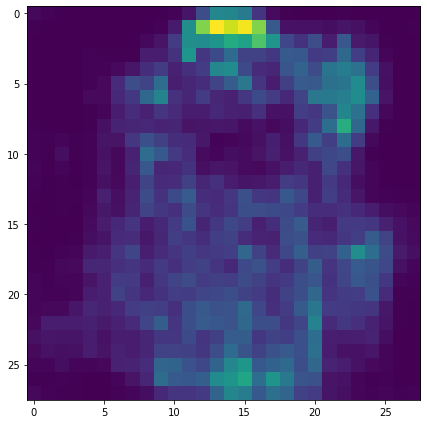

In [432]:
def draw_training_checkpoints_image(save_file_num=1):
    checkpoint_dir = '/home/june/Github/Exploration/data/ep11/training_checkpoints/training_checkpoints_{}'.format(save_file_num)
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    checkpoint.restore(latest)

    generator = checkpoint.generator
    discriminator = checkpoint.discriminator

    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)

    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.tight_layout()  
    plt.show() 
draw_training_checkpoints_image(1)

8) (optional) GAN 훈련 과정 개선하기

In [ ]:
cifar10 = tf.keras.datasets.cifar10
(train_x, _), (test_x, _) = cifar10.load_data()

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [ ]:
BUFFER_SIZE = 50000  
BATCH_SIZE = 128 

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def make_generator_model():

    g_kernel_size = 4
    g_LeakyReLU_alpha = 0.2

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer  # 32=8*4 이므로 8
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(512, kernel_size=(g_kernel_size, g_kernel_size), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=g_LeakyReLU_alpha))

    # Seventh: Conv2DTranspose layer  # output channel 설정
    model.add(layers.Conv2D(3, kernel_size=(g_kernel_size, g_kernel_size), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

In [ ]:
generator = make_generator_model()
generator.summary()

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

In [ ]:


    d_kernel_size = 3
    d_LeakyReLU_alpha = 0.2
    d_dropout_rate = 0.5

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (d_kernel_size, d_kernel_size), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(256, (d_kernel_size, d_kernel_size), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=d_LeakyReLU_alpha))
    model.add(layers.Dropout(d_dropout_rate))

    # FIfth: Flatten Layer
    model.add(layers.Flatten())

    # sixth: Dense Layer  # 숫자 1개(진짜라고 판단되는 정도)
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

In [ ]:
decision = discriminator(generated_image, training=False)

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
LR = 2e-4  # learning_rate
BETA_1=0.5

generator_optimizer = tf.keras.optimizers.Adam(LR, BETA_1, amsgrad=True)
discriminator_optimizer = tf.keras.optimizers.Adam(LR, BETA_1, amsgrad=True)

In [ ]:
noise_dim = 100  # 100차원
num_examples_to_generate = 16  # 샘플 16개

seed = tf.random.normal([num_examples_to_generate, noise_dim])  # 고정된 seed 노이즈
seed.shape  # (16,100) 벡터

In [ ]:
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
save_every = 5  # 모델 저장 간격
EPOCHS = 50  # 학습 횟수

In [ ]:
train(train_dataset, EPOCHS, save_every, 3)

In [ ]:
# Fake Images to GIF
make_a_gif(3, True)
# History Graphs to GIF
make_a_gif(3, False)
draw_training_checkpoints_image(3)

9) 루브릭


1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.

오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.


2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.

gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.


3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.

모델구조 변경 혹은 학습과정 개선 아이디어를 추가적으로 적용해보았고, 적용 전과 비교하였을 때의 내용을 표와 같은 시각적 자료로 작성하였다.

5) 회고

- 이번 프로젝트에서 **어려웠던 점,**



- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**



- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**



- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**



- **자기 다짐**

